### Homework C - Transformer network for video frame prediction ###

Create dataset of microscopy images

In [15]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

In [4]:
print(np.shape(dataset.resolve()))

(10, 64, 64, 1)


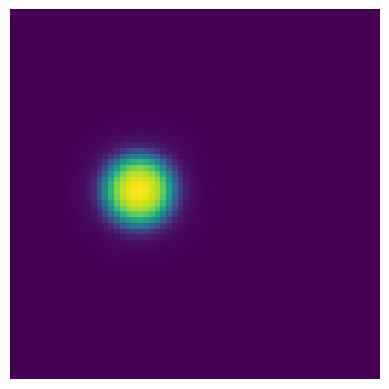

In [5]:
dataset.plot() # Plot first sequence

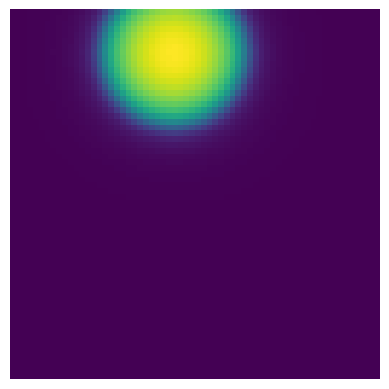

In [6]:
dataset.update().plot() # Plot updated sequence
video_sequence = dataset.update().resolve() # Get and store updated sequence

Problem 1) Convolutional autoencoder

In [10]:
# Create dataset - training, validation and test
def create_dataset(train_len, val_len, test_len):
    tot_len = train_len + val_len + test_len
    data = []
    for i in range(tot_len):
        data.extend(dataset.update().resolve())
    data = np.array(data)
    
    train_data = data[:train_len]
    val_data = data[train_len:train_len+val_len]
    test_data = data[train_len+val_len:]
    
    return train_data, val_data, test_data

train_data, val_data, test_data = create_dataset(train_len=1000, val_len=100, test_len=100)

In [33]:
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(1000, 64, 64, 1)
(100, 64, 64, 1)
(10900, 64, 64, 1)


In [57]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 1)), 
            # Encoder
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), 
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=4),
            layers.Flatten() # 2D -> 1D
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Reshape((4, 4, 8)), # 1D -> 2D
            
            # Decoder
            layers.Conv2DTranspose(8, kernel_size=5, strides=4, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=5, strides=4, activation='relu', padding='same'),
            layers.Conv2D(1, (3, 3), activation='linear', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.summary()
        
        

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 16)        4624      
                                                                 
 conv2d_59 (Conv2D)          (None, 4, 4, 8)           1160      
                                                                 
 flatten_19 (Flatten)        (None, 128)               0         
                                                                 
Total params: 6,104
Trainable params: 6,104
Non-trainable params: 0
_________________________________________________________________


Train the autoencoder 

In [60]:
autoencoder.fit(x=train_data, y=train_data, epochs=30, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/30
32/32 [==============================] - 3s 86ms/step - loss: 0.1616 - val_loss: 0.1828
Epoch 2/30
32/32 [==============================] - 2s 70ms/step - loss: 0.1570 - val_loss: 0.1803
Epoch 3/30
32/32 [==============================] - 2s 68ms/step - loss: 0.1545 - val_loss: 0.1767
Epoch 4/30
32/32 [==============================] - 2s 68ms/step - loss: 0.1569 - val_loss: 0.1734
Epoch 5/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1458 - val_loss: 0.1640
Epoch 6/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1397 - val_loss: 0.1551
Epoch 7/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1345 - val_loss: 0.1532
Epoch 8/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1345 - val_loss: 0.1526
Epoch 9/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1305 - val_loss: 0.1428
Epoch 10/30
32/32 [==============================] - 2s 66ms/step - loss: 0.1254 - val_loss: 0.1424
Epoch 11/

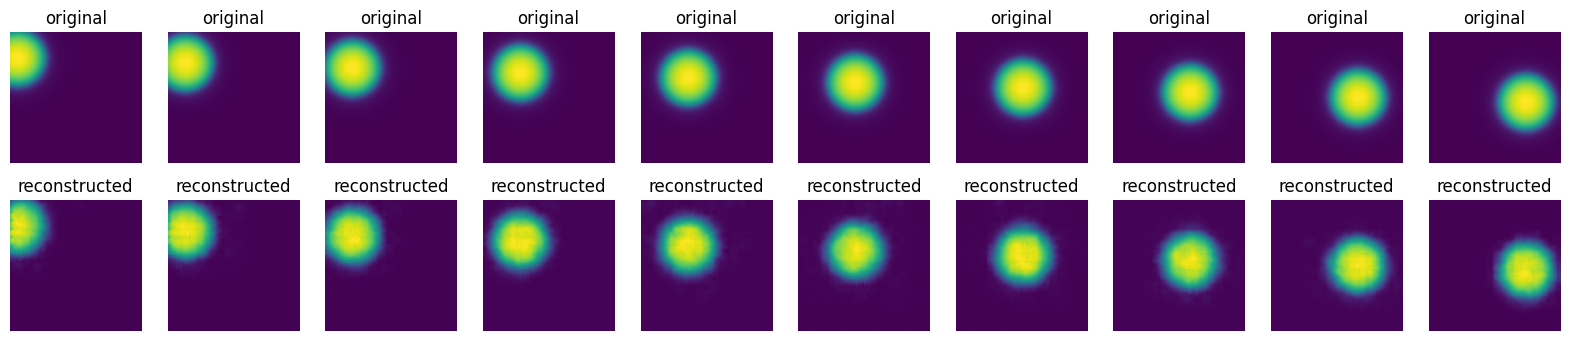

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

encoded_images = autoencoder.encoder(test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images): # plot original and reconstructed images for first sequence    
    ax = plt.subplot(2, n_images, i + 1) # original images
    plt.title("original")
    plt.imshow(tf.squeeze(test_data[i]))
    plt.axis("off")
    
    bx = plt.subplot(2, n_images, i+n_images+1) # reconstructed images
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_images[i]))
    plt.axis("off")
plt.show()